In [1]:
import pandas as pd
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F

import seaborn as sns

import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter

from sklearn.model_selection import train_test_split
import numpy as np
import torch
from sklearn.metrics import f1_score

In [2]:
device="mps"

In [3]:
df=pd.read_parquet("../../data/final_df.parquet")
df.shape

(188528, 5)

In [4]:
df

,prices,nifty,volume,returns,returns_fw
0,"[-0.018005549907684326, -0.011988699436187744,...","[-0.0017536552752143164, 0.006935970110392153,...","[0.3323798118585566, 0.8077187778001251, -0.21...",0.101157,0.112810
1,"[0.008794069290161133, -0.023661315441131592, ...","[0.0016670371193598932, -0.005439761614176253,...","[-0.2938680865155535, -0.4093075835777583, -0....",-0.082894,-0.159674
2,"[-0.001035451889038086, -0.009300589561462402,...","[-0.0044819973108015665, 0.004085307898817669,...","[-0.06950368727369238, -0.37902172497320485, 0...",0.014757,0.026520
3,"[-0.014811038970947266, 0.0077446699142456055,...","[0.0063298671124585315, 0.02111137390050777, 0...","[-0.22309353023186185, -0.3415447059989506, 0....",0.097998,0.125091
4,"[-0.018907904624938965, -0.0042574405670166016...","[-0.008847934580001326, 0.009582106122052902, ...","[-0.04456259292929021, 0.9305116877223019, -0....",-0.039779,-0.023309
...,...,...,...,...,...
188523,"[-0.05601811408996582, -0.007934331893920898, ...","[-0.017281188396425895, -0.01251917909122402, ...","[4.45524497347421, -0.45490027507506137, -0.19...",0.000782,-0.018043
188524,"[-0.008992493152618408, -0.014227509498596191,...","[0.009956329850809631, -0.015070680919024304, ...","[-0.2000696365359692, -0.15370339024036372, -0...",-0.139297,-0.109243
188525,"[-0.019580304622650146, -0.02121913433074951, ...","[0.00826226814041342, -0.0032251492066330822, ...","[-0.02790335997685267, -0.5280625058134127, -0...",0.099402,0.073026
188526,"[0.00039327144622802734, -0.019709110260009766...","[0.008133968552090476, -0.013126318808804993, ...","[-0.23070418028478046, -0.3590718678510948, 0....",0.078926,0.051571


In [23]:
df["ret_1"] = np.where(df["returns"] > 0.03, 1, 0)
df["ret_2"] = np.where(df["returns"] > 0.05, 1, 0)
df["ret_3"] = np.where(df["returns"] > 0.07, 1, 0)
df["ret_fw_1"] = np.where(df["returns_fw"] > 0.1, 1, 0)
df["ret_fw_2"] = np.where(df["returns_fw"] > 0.15, 1, 0)
df["ret_fw_3"] = np.where(df["returns_fw"] > 0.2, 1, 0)

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188528 entries, 0 to 188527
Data columns (total 11 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   prices      188528 non-null  object 
 1   nifty       188528 non-null  object 
 2   volume      188528 non-null  object 
 3   returns     188528 non-null  float64
 4   returns_fw  188528 non-null  float64
 5   ret_1       188528 non-null  int64  
 6   ret_2       188528 non-null  int64  
 7   ret_3       188528 non-null  int64  
 8   ret_fw_1    188528 non-null  int64  
 9   ret_fw_2    188528 non-null  int64  
 10  ret_fw_3    188528 non-null  int64  
dtypes: float64(2), int64(6), object(3)
memory usage: 15.8+ MB


In [25]:
df["ret_3"].value_counts()

ret_3
0    147073
1     41455
Name: count, dtype: int64

In [26]:
df.columns

Index(['prices', 'nifty', 'volume', 'returns', 'returns_fw', 'ret_1', 'ret_2',
       'ret_3', 'ret_fw_1', 'ret_fw_2', 'ret_fw_3'],
      dtype='object')

In [27]:
X_train, X_test, y_train, y_test = train_test_split( df[['prices', 'nifty', "volume"]], df[['ret_1', 'ret_2', 'ret_3', 'ret_fw_1', 'ret_fw_2', 'ret_fw_3']], test_size=0.15, random_state=42)
X_test, X_val, y_test, y_val = train_test_split( X_test[['prices', 'nifty', "volume"]], y_test[['ret_1', 'ret_2', 'ret_3', 'ret_fw_1', 'ret_fw_2', 'ret_fw_3']], test_size=0.5, random_state=42)

In [28]:
X_train.shape, X_test.shape, X_val.shape

((160248, 3), (14140, 3), (14140, 3))

In [29]:
def custom_collate_fn(batch):
    prices = torch.stack([item["prices"] for item in batch])
    nifty = torch.stack([item["nifty"] for item in batch])
    ret_1 = torch.stack([item["ret_1"] for item in batch])
    ret_2 = torch.stack([item["ret_2"] for item in batch])
    ret_3 = torch.stack([item["ret_3"] for item in batch])
    ret_fw_1 = torch.stack([item["ret_fw_1"] for item in batch])
    ret_fw_2 = torch.stack([item["ret_fw_2"] for item in batch])
    ret_fw_3 = torch.stack([item["ret_fw_3"] for item in batch])
    volume= torch.stack([item["volume"] for item in batch])

    return {
        "prices": prices,
        "nifty": nifty,
        "volume":volume,
        "ret_1": ret_1,
        "ret_2": ret_2,
        "ret_3": ret_3,
        "ret_fw_1": ret_fw_1,
        "ret_fw_2": ret_fw_2,
        "ret_fw_3": ret_fw_3
    }

In [30]:
class CustomDataset(Dataset):
    def __init__(self, X, y):
        # Convert each column of arrays (shape: [num_samples, seq_len]) into 2D np.array
        prices = np.stack(X["prices"].to_numpy())   # shape: (N, T)
        nifty = np.stack(X["nifty"].to_numpy())     # shape: (N, T)
        volume = np.stack(X["volume"].to_numpy())   # shape: (N, T)

        # Stack as channels → shape: (N, C=3, T)
        self.features = torch.tensor(
            np.stack([prices, nifty, volume], axis=1),  # axis=1 puts features as channels
            dtype=torch.float32
        )

        # Targets
        self.ret_1 = torch.tensor(y["ret_1"].values, dtype=torch.int64)
        self.ret_2 = torch.tensor(y["ret_2"].values, dtype=torch.int64)
        self.ret_3 = torch.tensor(y["ret_3"].values, dtype=torch.int64)
        self.ret_fw_1 = torch.tensor(y["ret_fw_1"].values, dtype=torch.int64)
        self.ret_fw_2 = torch.tensor(y["ret_fw_2"].values, dtype=torch.int64)
        self.ret_fw_3 = torch.tensor(y["ret_fw_3"].values, dtype=torch.int64)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return {
            "features": self.features[idx],  # (3, seq_len)
            "ret_1": self.ret_1[idx],
            "ret_2": self.ret_2[idx],
            "ret_3": self.ret_3[idx],
            "ret_fw_1": self.ret_fw_1[idx],
            "ret_fw_2": self.ret_fw_2[idx],
            "ret_fw_3": self.ret_fw_3[idx]
        }


batch_size = 32
train_dataset = CustomDataset(X_train, y_train)
val_dataset = CustomDataset(X_val, y_val)
test_dataset = CustomDataset(X_test, y_test)
val_loader = DataLoader(val_dataset, batch_size=batch_size )
test_loader = DataLoader(test_dataset, batch_size=batch_size)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [31]:
for batch in train_loader:
    print(batch["features"].shape)
    print(batch["ret_1"].shape)
    print(batch["ret_1"])
    print(batch["features"])
    
    break

torch.Size([32, 3, 200])
torch.Size([32])
tensor([0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1,
        1, 1, 1, 0, 1, 1, 0, 1])
tensor([[[ 5.5727e-03, -9.6982e-03,  6.3324e-03,  ...,  2.5186e-02,
          -5.4643e-03, -5.6729e-03],
         [ 4.7406e-03,  7.3512e-03,  4.9751e-03,  ...,  9.2468e-03,
           5.1903e-03,  3.1287e-03],
         [-7.9825e-01,  7.4006e+00,  1.9729e-01,  ...,  4.4717e-01,
          -1.6512e-01, -2.7627e-01]],

        [[ 1.1880e-02, -6.8555e-03,  3.9679e-03,  ...,  5.1122e-02,
          -2.4762e-02,  2.0462e-02],
         [ 4.3848e-03,  3.5982e-03, -4.9642e-03,  ...,  3.8904e-02,
           2.1756e-03, -4.3780e-02],
         [ 1.6540e-01, -2.7444e-01,  2.0116e-01,  ..., -1.9133e-01,
          -8.8362e-02, -3.7360e-02]],

        [[ 4.9980e-02,  4.9981e-02, -3.8177e-03,  ..., -2.2735e-02,
          -3.0794e-02,  4.0564e-02],
         [ 2.0334e-02, -2.5662e-02, -6.4532e-04,  ..., -9.0747e-03,
          -2.0428e-02,  2.1873e-03],
 

In [37]:
class Trainer():
    def __init__(self, model, optimizer, criterion, scheduler, checkpoint_path='best_model.pth', patience=3, log_dir='runs'):
        self.model = model
        self.optimizer = optimizer
        self.criterion = criterion
        self.scheduler = scheduler
        self.checkpoint_path = checkpoint_path
        self.patience = patience
        self.best_val_loss = np.inf
        self.early_stop_counter = 0
        self.all_train_loss = []
        self.all_train_accuracy = []
        self.all_val_loss = []
        self.all_val_accuracy = []
        self.all_train_f1 = []
        self.all_val_f1 = []
        # self.writer = SummaryWriter(log_dir=log_dir)

    def train(self, train_loader, val_loader, num_epochs=20):        
        for epoch in range(num_epochs):  
            self.model.train()
            correct = 0
            total = 0
            train_loss = 0
            predicted_label = []
            true_labels = []

            for batch in train_loader:
                features = batch["features"].to(device)
                labels = batch["ret_fw_3"].to(device)
                self.optimizer.zero_grad()  
                outputs = self.model(features)  
                # break
                loss = self.criterion(outputs, labels)  
                loss.backward() 
                train_loss += loss.item()
                self.optimizer.step()
                predicted = torch.argmax(outputs.data, dim=1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                true_labels.extend(labels.cpu().numpy())
                predicted_label.extend(predicted.cpu().numpy())

                
            # break
            train_f1= f1_score(true_labels, predicted_label, average='macro')
            train_accuracy = 100 * correct / total
            train_loss /= len(train_loader)
            self.all_train_loss.append(train_loss)
            self.all_train_accuracy.append(train_accuracy)

            val_loss, val_accuracy, val_f1 = self.validate(val_loader)

            self.all_val_loss.append(val_loss)
            self.all_val_accuracy.append(val_accuracy)
            self.all_train_f1.append(train_f1)
            self.all_val_f1.append(val_f1)

            # self.writer.add_scalar('Loss/Train', train_loss, epoch)
            # self.writer.add_scalar('Loss/Validation', val_loss, epoch)
            # self.writer.add_scalar('Accuracy/Train', train_accuracy, epoch)
            # self.writer.add_scalar('Accuracy/Validation', val_accuracy, epoch)

            if val_loss < self.best_val_loss:
                self.best_val_loss = val_loss
                torch.save(self.model.state_dict(), self.checkpoint_path)
                self.early_stop_counter = 0
            else:
                self.early_stop_counter += 1

            print(f'Epoch [{epoch + 1}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Train f1: {train_f1:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%, Val f1: {val_f1:.4f}')

            if self.early_stop_counter >= self.patience:
                print(f'Early stopping triggered after {epoch + 1} epochs.')
                break

            self.scheduler.step()

        # self.writer.close()

    def validate(self, val_loader):
        self.model.eval()
        correct = 0
        total = 0
        val_loss = 0
        predicted_label = []
        true_labels = []

        with torch.no_grad():
            for batch in val_loader:
                # prices = batch["prices"].to(device)
                # nifty= batch["nifty"].to(device)
                features = batch["features"].to(device)
                labels = batch["ret_fw_3"].to(device)
                outputs = self.model(features)
                val_loss += self.criterion(outputs, labels).item()
                predicted = torch.argmax(outputs.data, dim=1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                true_labels.extend(labels.cpu().numpy())
                predicted_label.extend(predicted.cpu().numpy())

        val_accuracy = 100 * correct / total
        val_loss /= len(val_loader)
        val_f1 = f1_score(true_labels, predicted_label, average='macro')
        return val_loss, val_accuracy, val_f1

    def test(self, test_loader):
        self.model.load_state_dict(torch.load(self.checkpoint_path))
        self.model.eval()
        correct = 0
        total = 0
        test_loss = 0
        real_labels = []
        predicted_labels = []

        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = self.model(images)
                test_loss += self.criterion(outputs, labels).item()
                predicted = torch.argmax(outputs.data, dim=1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                real_labels.extend(labels.cpu().numpy())
                predicted_labels.extend(predicted.cpu().numpy())

        test_accuracy = 100 * correct / total
        test_loss /= len(test_loader)

        print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')
        return real_labels, predicted_labels

    def plot_metrics(self):
        epochs = np.arange(1, len(self.all_train_loss) + 1)

        plt.figure(figsize=(12, 5))

        plt.subplot(1, 2, 1)
        plt.plot(epochs, self.all_train_loss, label='Train Loss')
        plt.plot(epochs, self.all_val_loss, label='Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Training and Validation Loss')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(epochs, self.all_train_accuracy, label='Train Accuracy')
        plt.plot(epochs, self.all_val_accuracy, label='Validation Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy (%)')
        plt.title('Training and Validation Accuracy')
        plt.legend()

        plt.tight_layout()
        plt.show()
    

Output_Length=⌊ 
stride
Input_Length+2⋅padding−kernel_size
​
 ⌋+1

In [44]:
def calc_out_len(input_len,  kernel_size=5, stride=1, padding=1):
    num=input_len + (2* padding) - kernel_size
    return (num/stride) + 1

calc_out_len(200, 5,1,0)


196.0

In [63]:
dummy = torch.zeros(1, 3, 200)  # assume 200 time steps
block_price_1 = nn.Conv1d(3, 30, kernel_size=5, stride=1, padding=0)
block_price_2 = nn.Conv1d(30, 64, kernel_size=5, stride=1, padding=0)
block_price_3 = nn.Conv1d(64, 128, kernel_size=5, stride=1, padding=0)

with torch.no_grad():
    dummy_out = block_price_3(block_price_2(block_price_1(dummy)))
    flattened_dim = dummy_out.view(dummy_out.size(0), -1).shape

In [64]:
flattened_dim

torch.Size([1, 24064])

In [ ]:
class ConvBlock(nn.Module):
    def __init__(self, input, output, kernel_size=5, stride=1, padding="same"):
        super(ConvBlock, self).__init__()
        self.conv1d = nn.Conv1d(input, output, kernel_size, stride, padding=padding)
        self.batch_norm = nn.BatchNorm1d(output)
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()
    def forward(self, x):
        x = self.conv1d(x)
        x = self.batch_norm(x)
        x = self.relu(x)
        x = self.pool(x)
        return x


In [55]:

class SimpleNet(nn.Module):
	def __init__(self):
		super(SimpleNet, self).__init__()

		self.block_price_1 = ConvBlock(3,30, padding=0)
		self.block_price_2 = ConvBlock(30,64, padding=0)
		self.block_price_3 = ConvBlock(64,128, padding=0)

		self.fc1 = nn.Linear(2688, 1024)
		self.fc2 = nn.Linear(1024, 512)
		self.fc3 = nn.Linear(512, 2)
	
	def forward(self, x):
		# Reshape input to [batch_size, 1, seq_length]
		# prices, nifty = prices.unsqueeze(1), nifty.unsqueeze(1)

		x = self.block_price_1(x)
		x = self.block_price_2(x)
		x = self.block_price_3(x)


		# combined = torch.cat([prices, nifty], dim=1)
		# print(x.shape)
		combined = x.view(x.size(0), -1)
		# print(combined.shape)
		

		combined = self.fc1(combined)
		combined = F.relu(combined)
		combined = self.fc2(combined)
		combined = F.relu(combined)
		combined = self.fc3(combined)
		return combined


  
model = SimpleNet()
model.to(device) 
model.train()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

trainer = Trainer(model, optimizer, criterion, scheduler, checkpoint_path='../../models/simple_cnn.pth', patience=3)

In [56]:
2688/4

672.0

In [57]:
trainer.train(train_loader, val_loader, num_epochs=20)

Epoch [1], Train Loss: 0.2278, Train Accuracy: 94.07%, Train f1: 0.4847, Val Loss: 0.2317, Val Accuracy: 93.90%, Val f1: 0.4843
Epoch [2], Train Loss: 0.2259, Train Accuracy: 94.08%, Train f1: 0.4848, Val Loss: 0.2298, Val Accuracy: 93.90%, Val f1: 0.4843
Epoch [3], Train Loss: 0.2254, Train Accuracy: 94.08%, Train f1: 0.4848, Val Loss: 0.2299, Val Accuracy: 93.90%, Val f1: 0.4843
Epoch [4], Train Loss: 0.2251, Train Accuracy: 94.08%, Train f1: 0.4848, Val Loss: 0.2302, Val Accuracy: 93.90%, Val f1: 0.4843
Epoch [5], Train Loss: 0.2251, Train Accuracy: 94.08%, Train f1: 0.4848, Val Loss: 0.2298, Val Accuracy: 93.90%, Val f1: 0.4843
Early stopping triggered after 5 epochs.


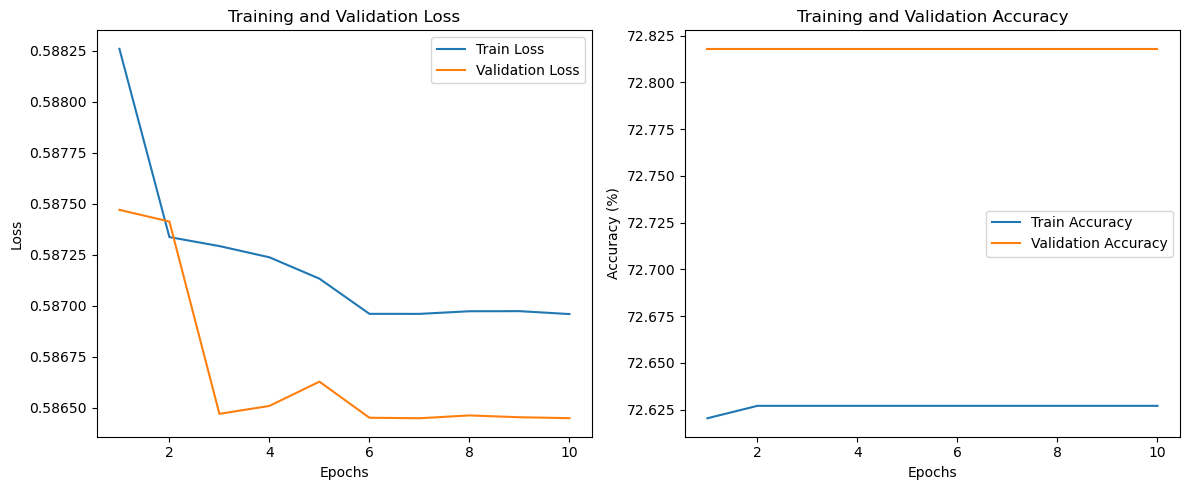

In [37]:
trainer.plot_metrics()

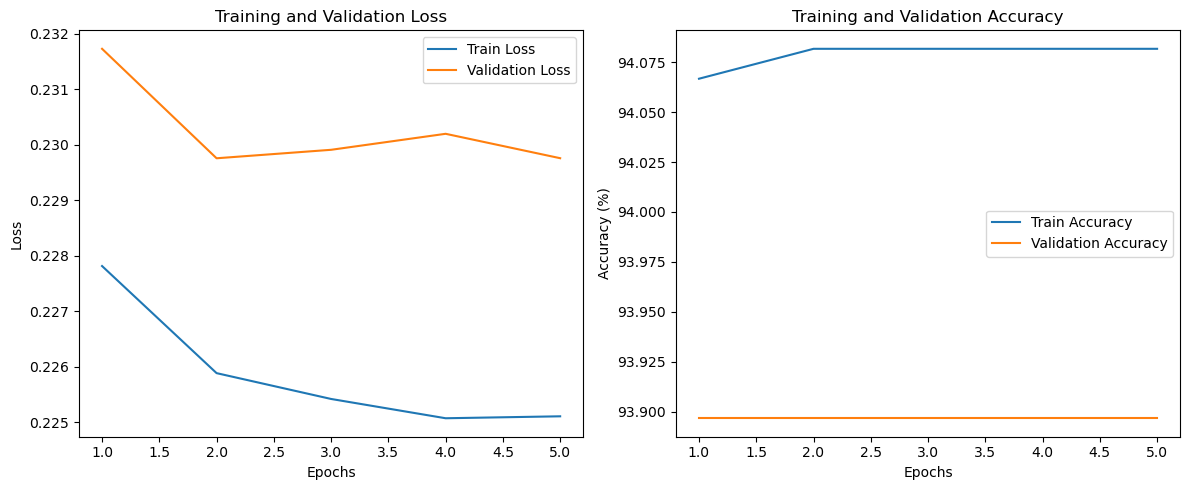

In [58]:
trainer.plot_metrics()